### **SSD MobileNet V2 FPNLite 640x640**

### **PIP Installs & Library Imports**

In [3]:
!pip install tflite-model-maker==0.3.2
!pip install -q pycocotools
!pip install -q tflite-support

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 591 kB 37.4 MB/s 
     |████████████████████████████████| 1.1 MB 55.7 MB/s 
     |████████████████████████████████| 128 kB 70.4 MB/s 
     |████████████████████████████████| 840 kB 68.1 MB/s 
     |████████████████████████████████| 78 kB 8.2 MB/s 
     |████████████████████████████████| 87 kB 7.7 MB/s 
     |████████████████████████████████| 238 kB 71.1 MB/s 
     |████████████████████████████████| 1.3 MB 51.1 MB/s 
     |████████████████████████████████| 60.2 MB 1.2 MB/s 
     |████████████████████████████████| 103 kB 73.5 MB/s 
     |████████████████████████████████| 352 kB 73.8 MB/s 
     |████████████████████████████████| 99 kB 11.3 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 40 kB 6.2 MB/s 
     |████████████████████████████████| 42.5 MB 1.2 MB/s 
     |████████████████████████████████| 

In [4]:
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import object_detector
from tflite_model_maker import model_spec
from google.colab import drive
import tensorflow as tf
from PIL import Image
import numpy as np
import glob
import cv2
import os

tf.get_logger().setLevel('ERROR')

from absl import logging
logging.set_verbosity(logging.ERROR)

### **Mount Google Drive**

In [5]:
# Mount Drive
drive.mount("/content/drive")

os.chdir("/content/drive/Shareddrives/CDT Team Challenge/ML/Datasets/Object Detection Tensorflow/data_V2BetterMaybe640X640/augmented_version_v2_processed")

Mounted at /content/drive


### **Load Dataset**

In [ ]:
train_data, val_data, test_data = object_detector.DataLoader.from_csv("augmented_v2_formatted_for_tf_object_detection.csv")

### **Create & Train Model**

In [ ]:
# To make this run, went to the source code of the API where these lines are defined:
#     policy = tf.keras.mixed_precision.experimental.Policy(precision)
#     tf.keras.mixed_precision.experimental.set_policy(policy)
# and changed them to:
#     policy = tf.keras.mixed_precision.Policy(precision)
#     tf.keras.mixed_precision.set_global_policy(policy)
# as the experimental version of Keras was removed depreciating the model_spec function

spec = model_spec.get('efficientdet_lite2')

In [ ]:
spec.config.tflite_max_detections = 90
spec.config.max_instances_per_image = 999

In [ ]:
model = object_detector.create(train_data, model_spec=spec, batch_size=4, train_whole_model=True, epochs=28, validation_data=val_data)

Epoch 1/28
51/51 [==============================] - 73s 426ms/step - det_loss: 2.0526 - cls_loss: 0.9074 - box_loss: 0.0229 - reg_l2_loss: 0.0759 - loss: 2.1285 - learning_rate: 0.0065 - gradient_norm: 5.7049 - val_det_loss: 2.0231 - val_cls_loss: 0.8093 - val_box_loss: 0.0243 - val_reg_l2_loss: 0.0760 - val_loss: 2.0991
Epoch 2/28
51/51 [==============================] - 18s 359ms/step - det_loss: 1.3586 - cls_loss: 0.6648 - box_loss: 0.0139 - reg_l2_loss: 0.0761 - loss: 1.4347 - learning_rate: 0.0050 - gradient_norm: 4.6892 - val_det_loss: 1.7903 - val_cls_loss: 0.7492 - val_box_loss: 0.0208 - val_reg_l2_loss: 0.0761 - val_loss: 1.8664
Epoch 3/28
51/51 [==============================] - 18s 355ms/step - det_loss: 1.2177 - cls_loss: 0.5533 - box_loss: 0.0133 - reg_l2_loss: 0.0761 - loss: 1.2938 - learning_rate: 0.0049 - gradient_norm: 4.7731 - val_det_loss: 1.1505 - val_cls_loss: 0.5536 - val_box_loss: 0.0119 - val_reg_l2_loss: 0.0761 - val_loss: 1.2267
Epoch 4/28
51/51 [=============

### **Evaluate & Save Model**

In [ ]:
model.evaluate(test_data)

1/1 [==============================] - 7s 7s/step



{'AP': 0.37130746,
 'AP50': 0.69894916,
 'AP75': 0.35823894,
 'APs': 0.10895556,
 'APm': 0.61633664,
 'APl': -1.0,
 'ARmax1': 0.3712186,
 'ARmax10': 0.39412042,
 'ARmax100': 0.48451874,
 'ARs': 0.23518519,
 'ARm': 0.6666667,
 'ARl': -1.0,
 'AP_/cyano': 0.109941654,
 'AP_/algal': 0.63267326}

In [ ]:
model.export(export_dir='/content/drive/Shareddrives/CDT Team Challenge/ML/Models/Object Detection/', tflite_filename='augmented_lite2_v2_object_detection_epochs_28.tflite')

### **Use Model To Detect Cyanobacteria in Our Images**

In [8]:
# Load the labels into a list
classes = ['cyano', 'algal']
label_map = {1: 'cyano', 2: 'algal'}
for label_id, label_name in label_map.items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

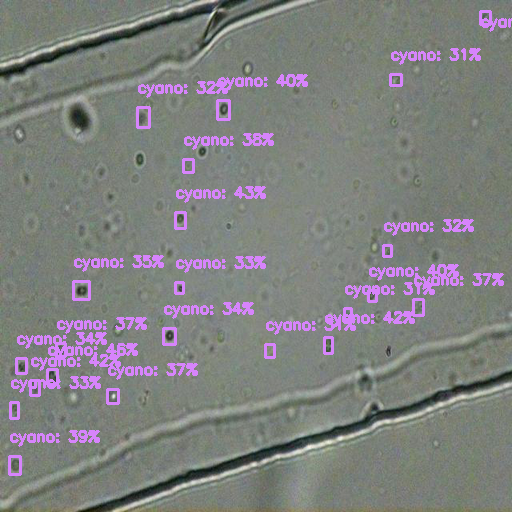

In [ ]:
INPUT_IMAGE = "/content/drive/Shareddrives/CDT Team Challenge/ML/Datasets/Object Detection Tensorflow/data_V2BetterMaybe640X640/augmented_version_v2_processed/m_068_jpg.rf.082ebbc9c2d67f94acd5b1b90c5f9713.jpg"
DETECTION_THRESHOLD = 0.3

TEMP_FILE = '/tmp/image.png'

im = Image.open(INPUT_IMAGE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/Shareddrives/CDT Team Challenge/ML/Models/Object Detection/augmented_lite2_v2_object_detection_epochs_28.tflite')
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

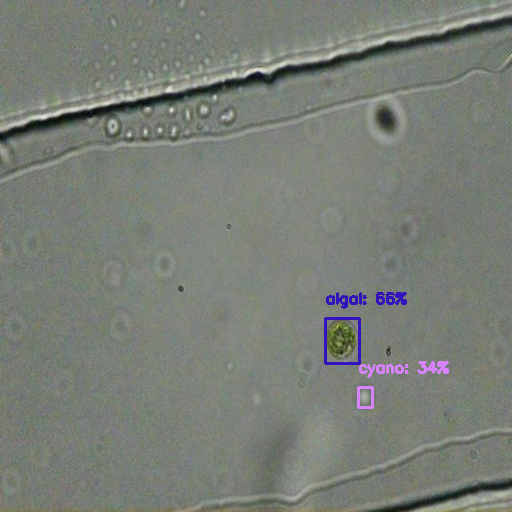

In [ ]:
INPUT_IMAGE = "/content/drive/Shareddrives/CDT Team Challenge/ML/Datasets/Object Detection Tensorflow/data_V2BetterMaybe640X640/augmented_version_v2_processed/a_017_jpg.rf.b6a7b5d27f8dd0db12cdb3666d725861.jpg"
DETECTION_THRESHOLD = 0.3

TEMP_FILE = '/tmp/image2.png'

im = Image.open(INPUT_IMAGE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/Shareddrives/CDT Team Challenge/ML/Models/Object Detection/augmented_lite2_v2_object_detection_epochs_28.tflite')
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

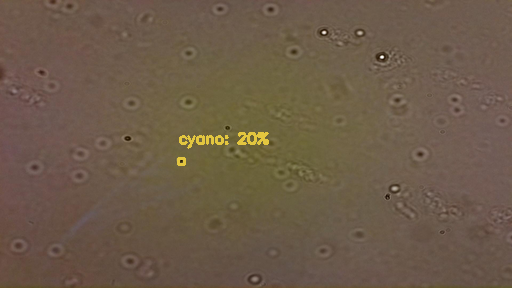

In [13]:
INPUT_IMAGE = "/content/drive/Shareddrives/CDT Team Challenge/ML/Datasets/Object Detection Tensorflow/2022-08-19_6803_1_10_vid2-images/030 - Copy.jpg"
DETECTION_THRESHOLD = 0.2

TEMP_FILE = '/tmp/image2.png'

im = Image.open(INPUT_IMAGE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/Shareddrives/CDT Team Challenge/ML/Models/Object Detection/augmented_lite2_v2_object_detection_epochs_28.tflite')
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

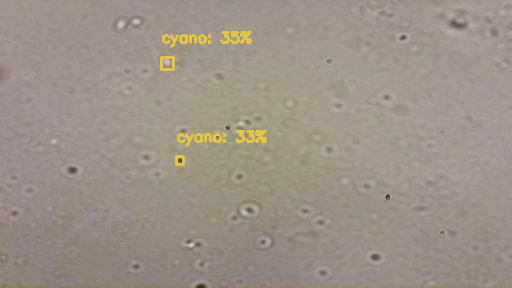

In [23]:
INPUT_IMAGE = "/content/drive/Shareddrives/CDT Team Challenge/Microscopy/micrographs/Videos/Images/New images extraction 2/Good Videos 2/2022-08-17_6803_2/020.jpg"
DETECTION_THRESHOLD = 0.28

TEMP_FILE = '/tmp/image2.png'

im = Image.open(INPUT_IMAGE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/Shareddrives/CDT Team Challenge/ML/Models/Object Detection/augmented_lite2_v2_object_detection_epochs_28.tflite')
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)